In [42]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from datetime import datetime as dt
import pickle
import xgboost as xgb

In [43]:
df=pd.read_csv('../dataset/updated_train1.csv')

In [44]:
#データクレンジング
def clean(df):
    df1=df.dropna()
    df1.set_index('store_id_date',drop=True,inplace=True)
    return df1

In [45]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [46]:
df1=clean(df)

In [47]:
#trainデータとvalidationデータに分割
X = df1.drop('visitors', axis=1).as_matrix()
y = df1['visitors']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 666)

In [55]:
# parameter tuning of xgboost
# start from default setting
boost_params = {'eval_metric': 'rmse'}
xgb0 = xgb.XGBRegressor(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    objective='reg:linear',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    scale_pos_weight=1,
    seed=27,
    **boost_params)

In [56]:
#学習
xgb0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=1)

In [57]:
#予測
y_test_pred = xgb0.predict(X_test)
y_train_pred= xgb0.predict(X_train)

In [58]:
#評価
#RMSEで評価
print('trainのRMSE：',rmsle(y_train,y_train_pred))
print('validationのRMSE：',rmsle(y_test,y_test_pred))

#R2scoreで評価
print('trainのR2：',r2_score(y_train,y_train_pred))
print('validationのR2：',r2_score(y_test,y_test_pred))

trainのRMSE： 0.5061763183875992
validationのRMSE： 0.53194851419127
trainのR2： 0.698476871022
validationのR2： 0.585643511217


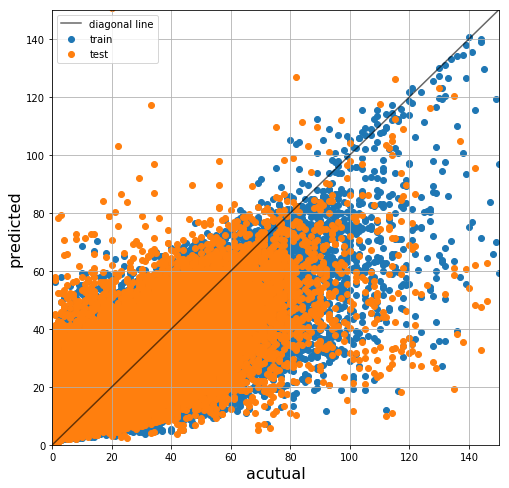

In [59]:
u_lim=150
l_lim=0
plt.figure(figsize=(8, 8))
plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
plt.scatter(y_train,y_train_pred,label='train')
plt.scatter(y_test,y_test_pred,label='test')
plt.xlim(l_lim,u_lim)
plt.ylim(l_lim,u_lim)
plt.xlabel('acutual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [60]:
with open('xgb.pickle', mode='wb') as f:
    pickle.dump(xgb0, f)